# Section 5

This file runs the per-fold ranking using feature importance for our top two performing classifiers from Section 4. In the paper, these classifiers were the logistic regression and LGBM. The procedure is model-specific. Here, we don't have weighted (w) and unweighted (u) versions of the data as in the original pipeline; it is, however, the same procedure for both.

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

# local modules
from _utils import *

from functools import reduce
from typing import List
from matplotlib import pyplot as plt

In [2]:
# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=10)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [3]:
# working directory
os.chdir("..")
wd = os.getcwd()
# data folder
data_path = wd + '/' + 'data' + '/'
# results folder
resu_path = wd + '/' + 'results' + '/'

## Setting parameters

In [4]:
# types of datasets
ls_clf_type     = ['LGBM2', 'LR']
ls_dataset_type = ['bible_belt']
# ls_dataset_type = ['item', 'theme']  # See paper for details: We don't have this type of data setting

# store all results here
all_results = {}

# top-k
k = 10

In [5]:
# use 'w' for weighted or 'u' for unweighted - the latter used as default
experiment_type = 'u' 

if experiment_type == 'w':
    filename = 'experiment_results_w.pkl'
    print('---> run WEIGHTED')
else:
    filename = 'experiment_results.pkl'
    print('---> run UNWEIGHTED')

---> run UNWEIGHTED


In [6]:
# check for exisiting results
all_results.keys()

dict_keys([])

In [7]:
# we use the results from Section 4 - hence, load from results folder
with open(resu_path + filename, 'rb') as f: 
    [target, 
     categorical_columns, 
     cat_feats, con_feats, ord_feats, all_feats, 
     state_encoder, sex_encoder, race_encoder, 
     weight_column, 
     dataset, 
     experiment_results, final_results] = pickle.load(f)

In [8]:
dataset.head(5)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y,STATE
0,32.0,2.0,19.0,5.0,5510.0,2.0,7.0,40.0,0,6,1,0
1,61.0,4.0,16.0,1.0,4220.0,2.0,1.0,40.0,1,4,0,0
2,65.0,2.0,21.0,1.0,6200.0,2.0,0.0,35.0,1,3,1,0
3,38.0,1.0,17.0,4.0,310.0,46.0,0.0,30.0,0,6,0,0
4,50.0,1.0,21.0,1.0,3255.0,328.0,0.0,50.0,0,1,1,0


## Extract and rank feature importance

In [10]:
for clf_type in ls_clf_type:
    print(clf_type)
    
# ---------- ---------- ---------- ---------- ----------
    
    for dataset_type in ls_dataset_type:
        print(dataset_type)
        
        # Get clf-dataset type specific experimental results
        temp_experiment_results = experiment_results[(experiment_results['clf_name'] == clf_type) & (experiment_results['dataset'] == dataset_type)]
        print(temp_experiment_results.shape)
        
        # define dataset
        X = dataset.copy()
        y = X[target]
        X.drop(columns = [target], inplace = True)
        print(y.shape)
        print(X.shape)
        
#         # define dataset
#         X = datasets[dataset_type].copy()
#         y = X[target]
#         X.drop(columns = [target], inplace = True)
#         print(y.shape)
#         print(X.shape)
        
# ---------- ---------- ---------- ---------- ----------
        
        # store internal results
        temp_fold_results = []
        temp_rank_results = []

        fold = 0
        
        for ind, row in temp_experiment_results.iterrows():
    
            fold += 1
    
            # training set
            train = row['train']
            X_train = X.iloc[train]
            y_train = y.iloc[train]
            sw_train = weight_column.iloc[train] if weight_column is not None else None
            # test set
            test = row['test']
            X_test = X.iloc[test]
            y_test = y.iloc[test]
            sw_test = weight_column.iloc[test] if weight_column is not None else None
    
            # build model
            clf = build_model(row['clf_name'], categorical_columns, row['best_hyparams'])
            # fit model
            clf.fit(X_train, y_train, clf__sample_weight=sw_train)
            # test model
            y_scores = clf.predict_proba(X_test)[:,1] 
            ap = average_precision_score(y_test, y_scores, sample_weight=sw_test)
            # should be the same!
            #print(ap , row['ap_test'])
    
            coef_col_name = 'imp_f' + str(fold) # for LR imp is the coefs and for LGBM is the feat_importance
            ranking = 'rank_f' + str(fold)

            if clf_type == 'LR':        
                # get imp
                temp_betas_0 = pd.DataFrame(zip(clf['one hot'].get_feature_names(), 
                                                np.transpose(clf['clf'].coef_)), 
                                          columns=['features', coef_col_name])
                # remove [] and round up
                temp_betas_0[coef_col_name] = temp_betas_0[coef_col_name].map(lambda x: round(x[0], 3)) # only diff wrt LGBM

                # store
                temp_fold_results.append(temp_betas_0)
                temp_betas = temp_betas_0.copy()
                # clear
                del temp_betas_0

                # get ranking
                temp_betas[coef_col_name] = temp_betas[coef_col_name].map(lambda x: abs(x)) # only diff wrt LGBM
                temp_betas.sort_values(by=coef_col_name, ascending=False, inplace=True)
                temp_betas[ranking] = temp_betas[coef_col_name].rank(method='dense', ascending=False).astype(int)
                temp_betas.drop([coef_col_name], axis=1, inplace=True)

                # store
                temp_rank_results.append(temp_betas)

            else: # only for LGBM2
                # get imp
                temp_betas_0 = pd.DataFrame(zip(clf['one hot'].get_feature_names(), 
                                                np.transpose(clf['clf'].feature_importances_)), 
                                            columns=['features', coef_col_name])

                # store
                temp_fold_results.append(temp_betas_0)
                temp_betas = temp_betas_0.copy()
                # clear
                del temp_betas_0

                # get ranking
                temp_betas.sort_values(by=coef_col_name, ascending=False, inplace=True)
                temp_betas[ranking] = temp_betas[coef_col_name].rank(method='dense', ascending=False).astype(int)
                temp_betas.drop([coef_col_name], axis=1, inplace=True)

                # store
                temp_rank_results.append(temp_betas)

            # clear
            del temp_betas, coef_col_name

        print(len(temp_fold_results))
        print(len(temp_rank_results))
        
# ---------- ---------- ---------- ---------- ----------
        
        # get fold results
        fold_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='features'), temp_fold_results)
        fold_results.set_index(['features'], drop=True, inplace=True)
        
        print(fold_results.shape)
        fold_results_org = fold_results.copy()
        
        fold_results['imp_avg'] = fold_results.mean(axis=1)
        fold_results['imp_std'] = fold_results.std(axis=1)
        if clf_type == 'LR':
            fold_results['abs_imp_avg'] = fold_results['imp_avg'].abs()
            res1 = fold_results.sort_values(by=['abs_imp_avg'], 
                                            ascending=[False], axis=0)[['abs_imp_avg', 'imp_avg', 'imp_std']] #.head(top_k)
        else:
            res1 = fold_results.sort_values(by=['imp_avg'], 
                                            ascending=[False], axis=0)[['imp_avg', 'imp_std']] #.head(top_k)
        
        # get rankings
        rank_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='features'), temp_rank_results)
        rank_results.set_index(['features'], drop=True, inplace=True)
        
        print(rank_results.shape)
        rank_results_org = rank_results.copy()
        
        rank_results['final_ranking_points'] = rank_results.sum(axis=1) #round(rank_results.sum(axis=1) / 100)
        #^ so 100 would be the perfect score is it means the feat was ranked 1st over all 100 folds
        rank_results.sort_values(by=['final_ranking_points'], 
                                 ascending=[True], axis=0, inplace=True)
        rank_results['final_ranking'] = rank_results['final_ranking_points'].rank(method='first').astype(int)
        res2 = rank_results[['final_ranking_points', 'final_ranking']] #.head(top_k)

# ---------- ---------- ---------- ---------- ----------
        
        # store results
        run_type = experiment_type + '_' + clf_type + '_' + dataset_type

        print(run_type)

        all_results[run_type] = {}
        all_results[run_type]['fold_results'] = fold_results_org
        all_results[run_type]['rank_results'] = rank_results_org
        all_results[run_type]['feat_desc'] = res1
        all_results[run_type]['feat_rank'] = res2
        all_results[run_type]['top_k'] = res2.index.to_list()[:k]

        del run_type
        del fold_results_org, rank_results_org, fold_results, rank_results, res1, res2

# ---------- ---------- ---------- ---------- ----------

print('DONE')

print(all_results.keys())

LGBM2
bible_belt
(6, 9)
(235893,)
(235893, 11)
[LightGBM] [Warning] feature_fraction is set=0.7789355153603348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7789355153603348
[LightGBM] [Warning] lambda_l1 is set=0.6437596878291109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6437596878291109
[LightGBM] [Warning] bagging_fraction is set=0.8577577792661564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577577792661564
[LightGBM] [Warning] lambda_l2 is set=0.40648792269514766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40648792269514766
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] feature_fraction is set=0.7141653713024363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141653713024363
[LightGBM] [Warning] lambda_l1 is set=0.10020647866897148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10020647866897148
[LightGBM] [Warning] bagging_fraction is set=0.5194238019233199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194238019233199
[LightGBM] [Warning] lambda_l2 is set=0.42165623504513017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42165623504513017
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] feature_fraction is set=0.9089757436394137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9089757436394137
[LightGBM] [Warning] lambda_l1 is set=0.6844317511858413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6844317511858413
[LightGBM] [Warning] bagging_fraction is set=0.7551290984043468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551290984043468
[LightGBM] [Warning] lambda_l2 is set=0.6739354941526675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6739354941526675
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] feature_fraction is set=0.9174432270540904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9174432270540904
[LightGBM] [Warning] lambda_l1 is set=0.5034380303298535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5034380303298535
[LightGBM] [Warning] bagging_fraction is set=0.8106775600700995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8106775600700995
[LightGBM] [Warning] lambda_l2 is set=0.7149633063650149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7149633063650149
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] feature_fraction is set=0.8650214129011375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650214129011375
[LightGBM] [Warning] lambda_l1 is set=0.4077438359838218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4077438359838218
[LightGBM] [Warning] bagging_fraction is set=0.96264223918917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96264223918917
[LightGBM] [Warning] lambda_l2 is set=0.9083064687048718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9083064687048718
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] feature_fraction is set=0.8619465806149611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8619465806149611
[LightGBM] [Warning] lambda_l1 is set=0.19603436619603887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19603436619603887
[LightGBM] [Warning] bagging_fraction is set=0.8068846776736418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8068846776736418
[LightGBM] [Warning] lambda_l2 is set=0.3202664490245678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3202664490245678
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


6
6
(506, 6)
(506, 6)
u_LGBM2_bible_belt
LR
bible_belt
(6, 9)
(235893,)
(235893, 11)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of ite

6
6
(506, 6)
(506, 6)
u_LR_bible_belt
DONE
dict_keys(['u_LGBM2_bible_belt', 'u_LR_bible_belt'])


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Prepare the rankings

In [12]:
for run_type in all_results.keys():
    
    # Feature feat. imp. description
    name1 = "\\"  + "lar_" + run_type + "_" + 'feat_desc'
    all_results[run_type]['feat_desc'].to_csv(resu_path + name1 + '.csv')
    
    # Feature feat. imp. ranking
    name2 = "\\" + "lar_" + run_type + "_" + 'feat_rank'
    all_results[run_type]['feat_rank'].to_csv(resu_path + name2 + '.csv')
    
    del name1, name2

In [15]:
all_results['u_LGBM2_bible_belt']['top_k']

['AGEP',
 'WKHP',
 'COW',
 'POBP',
 'SCHL',
 'RELP',
 'onehot__x0_0',
 'onehot__x1_6',
 'onehot__x4_3255.0',
 'onehot__x2_2']

In [16]:
all_results['u_LR_bible_belt']['top_k']

['WKHP',
 'SCHL',
 'onehot__x4_1106.0',
 'AGEP',
 'onehot__x4_4930.0',
 'onehot__x4_1320.0',
 'onehot__x4_300.0',
 'onehot__x4_1350.0',
 'onehot__x4_4030.0',
 'onehot__x4_820.0']

In [21]:
# # TABLE 1
# df_res_items = pd.DataFrame()

# for i in dict((k, all_results[k]) for k in res_items).keys():
#     df_res_items[i] = all_results[i]['top_k']

# df_res_items['Ranking'] = df_res_items.index + 1
# df_res_items

# # For Latex document
# print(df_res_items.to_latex(index=False))

In [22]:
# # TABLE 2
# df_res_themes = pd.DataFrame()

# for i in dict((k, all_results[k]) for k in res_themes).keys():
#     df_res_themes[i] = all_results[i]['top_k']

# df_res_themes

# # for latex output
# print(df_res_themes.to_latex(index=False))

## Critical difference test for LGBM classifier for top-k

We finalize by running the comparisson between the classifier for the top-k. We focus on the LGBM as it's our main model for this section and, thus, run the CD test on the bible belt datasets. Note that in the paper this procedure (as with the feature importance ranking) is done for weighted and unweighted versions of the dataset as well as for the item and theme datasets from the survey data.

In [23]:
from autorank import autorank, create_report, plot_stats, latex_table
from matplotlib import pyplot as plt

In [24]:
lgbm2 = all_results['u_LGBM2_bible_belt']['fold_results'].transpose()[all_results['u_LGBM2_bible_belt']['top_k']].copy()

In [26]:
lgbm2.head(k)

features,AGEP,WKHP,COW,POBP,SCHL,RELP,onehot__x0_0,onehot__x1_6,onehot__x4_3255.0,onehot__x2_2
imp_f1,373,300,268,119,225,112,71,39,44,31
imp_f2,265,215,215,134,213,115,52,32,46,32
imp_f3,994,761,598,560,521,320,129,101,104,78
imp_f4,3058,2054,1292,2253,1513,852,286,233,132,191
imp_f5,571,454,450,269,363,228,126,65,84,51
imp_f6,2019,1456,927,1415,1092,655,194,180,123,133


The statistical analysis was conducted for 10 populations with 6 paired samples.
The family-wise significance level of the tests is alpha=0.001.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.101). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.000) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference

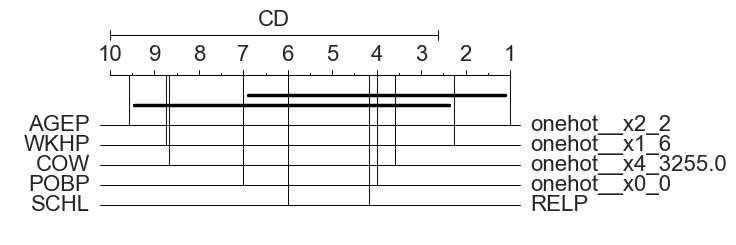

\begin{table}[h]
\centering
\begin{tabular}{lrrrlll}
\toprule
{} &    MR &        M &       SD &                     CI &    \$d\$ &   Magnitude \\
features          &       &          &          &                        &        &             \\
\midrule
onehot\_\_x2\_2      & 9.583 &   86.000 &   63.975 &    [-205.936, 377.936] &  0.000 &  negligible \\
onehot\_\_x1\_6      & 8.750 &  108.333 &   81.539 &    [-263.754, 480.420] & -0.305 &       small \\
onehot\_\_x4\_3255.0 & 8.667 &   88.833 &   37.759 &     [-83.473, 261.140] & -0.054 &  negligible \\
onehot\_\_x0\_0      & 7.000 &  143.000 &   86.023 &    [-249.548, 535.548] & -0.752 &      medium \\
RELP              & 6.000 &  380.333 &  305.667 &  [-1014.511, 1775.177] & -1.333 &       large \\
SCHL              & 4.167 &  654.500 &  531.153 &  [-1769.299, 3078.299] & -1.503 &       large \\
POBP              & 4.000 &  791.667 &  864.395 &  [-3152.812, 4736.145] & -1.151 &       large \\
COW               & 3.583 &  625.000 & 

C:\Users\jose\AppData\Roaming\Python\Python39\site-packages\autorank\autorank.py:697: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_string = table_df.to_latex(float_format=float_format, na_rep='-').strip()


<Figure size 640x480 with 0 Axes>

In [28]:
lg_res = autorank(lgbm2, alpha=0.001, verbose=False)
create_report(lg_res)
plot_stats(lg_res)
plt.show()
plt.savefig(fname = resu_path + 'lar_cd_lg.pdf', bbox_inches='tight', dpi=400)
latex_table(lg_res)